# Introduction

Hello, my name is Aaron Chien and I am using the 'Industrial Safety and Health Analytics Database' from Kaggle as an introductury project on python. The CSV file includes accidents that have occured in difference countries and includes multiple columns. In this project, I would analyze these accidents and see what we can do to predict these accidents.

Let's view and clean the data

In [1]:
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns 

import matplotlib.pyplot as plt 

import pandas as pd

import numpy as np

import math

import pickle

import dbm

import os

from sklearn.impute import SimpleImputer
import sys

from statistics import mode

import datetime

from functools import partial, reduce

In [2]:
# timeline of accident
# figure out which plants and which countries and great map of it showing average accident occurances 
# ratio of men and women, types of employees, etc
# figure out predicted accident level from potential accident level, lowest slope is the safest 

In [3]:
sys.path.append("/Users/aaron/Accident")

In [4]:
indust = pd.read_csv("industrial.csv")

In [5]:
indust.head()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others


Since some of these column names are in spanish, let's translate those into spanish!

In [6]:
indust.rename(columns = {"Employee ou Terceiro" : 'Employee_or_Third_Party', 'Risco Critico' : 'Critical_Risk',
                         'Industry Sector' : 'Industry', 'Accident Level' : 'Accident_Level',
                         'Potential Accident Level' : 'Potential_Accident_Level', 'Data' : 'Date', 
                         'Genre' : 'Gender'},
              inplace = True)

In [7]:
indust.head()

,Date,Countries,Local,Industry,Accident_Level,Potential_Accident_Level,Gender,Employee_or_Third_Party,Critical_Risk
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others


Now let's see what unique values are in each separate column to see which columns are interesting.

In [8]:
print(indust.Countries.unique());
print(indust.Local.unique());
print(indust.Industry.unique()); 
print(indust.Employee_or_Third_Party.unique()); 
print(indust.Critical_Risk.unique());
print(indust.Gender.unique());
print(indust.Accident_Level.unique())

['Country_01' 'Country_02' 'Country_03']
['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
['Mining' 'Metals' 'Others']
['Third Party' 'Employee' 'Third Party (Remote)']
['Pressed' 'Pressurized Systems' 'Manual Tools' 'Others'
 'Fall prevention (same level)' 'Chemical substances' 'Liquid Metal'
 'Electrical installation' 'Confined space'
 'Pressurized Systems / Chemical Substances'
 'Blocking and isolation of energies' 'Suspended Loads' 'Poll' 'Cut'
 'Fall' 'Bees' 'Fall prevention' '\nNot applicable' 'Not applicable'
 'Traffic' 'Projection' 'Venomous Animals' 'Plates' 'Projection/Burning'
 'remains of choco' 'Vehicles and Mobile Equipment' 'Projection/Choco'
 'Machine Protection' 'Power lock' 'Burn' 'Projection/Manual Tools'
 'Individual protection equipment' 'Electrical Shock'
 'Projection of fragments']
['Male' 'Female']
['I' 'IV' 'III' 'II' 'V']


Now that we know what unique values there are, let's convert the Date column into a date object

In [9]:
indust['Date'] = pd.to_datetime(indust['Date'])

We need to turn the roman numerals into numbers for easier manipulation!

In [10]:
# turn roman numerals into numbers up to 5
def roman_num(x):
    y = []
    for i in range(0,len(x)) :
        if x[i] == "I":
            y.append(1)
        elif x[i] == "II":
            y.append(2)
        elif x[i] == "III":
            y.append(3)
        elif x[i] == "IV":
            y.append(4)
        else:
            y.append(5)
    return(y)

In [11]:
'''Would this work?
def roman_num(x):
    for i in range(0,len(x)) :
        if x[i] == "I":
            x[i] = 1
        elif x[i] == "II":
            x[i] = 2
        elif x[i] == "III":
            x[i] = 3
        elif x[i] == "IV":
            x[i] = 4
        else:
            x[i] = 5
    return(x)
'''

'Would this work?\ndef roman_num(x):\n    for i in range(0,len(x)) :\n        if x[i] == "I":\n            x[i] = 1\n        elif x[i] == "II":\n            x[i] = 2\n        elif x[i] == "III":\n            x[i] = 3\n        elif x[i] == "IV":\n            x[i] = 4\n        else:\n            x[i] = 5\n    return(x)\n'

Converting Accident levels

In [12]:
n1 = roman_num(indust["Accident_Level"]) 
n2 = roman_num(indust["Potential_Accident_Level"])

In [13]:
indust.drop(['Potential_Accident_Level', 'Accident_Level'], axis = 1, inplace = True)

In [14]:
indust['Accident_Level'] = n1
indust['Potential_Accident_Level'] = n2
indust['Avoided_Accident_Level'] = indust['Potential_Accident_Level'] - indust['Accident_Level']

Creating months column in the data 

In [15]:
d

In [16]:
indust.head()

,Date,Countries,Local,Industry,Gender,Employee_or_Third_Party,Critical_Risk,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level,months
0,2016-01-01,Country_01,Local_01,Mining,Male,Third Party,Pressed,1,4,3,1/2016
1,2016-01-02,Country_02,Local_02,Mining,Male,Employee,Pressurized Systems,1,4,3,1/2016
2,2016-01-06,Country_01,Local_03,Mining,Male,Third Party (Remote),Manual Tools,1,3,2,1/2016
3,2016-01-08,Country_01,Local_04,Mining,Male,Third Party,Others,1,1,0,1/2016
4,2016-01-10,Country_01,Local_04,Mining,Male,Third Party,Others,4,4,0,1/2016


# Creating Timeline of Accidents per Month

Creating data frame of the mean of the accident levels for each month for clean graphing

In [17]:
timeline = indust.groupby("months")[['Accident_Level', 'Potential_Accident_Level','Avoided_Accident_Level']].mean().reset_index()

In [18]:
timeline['months'] = pd.to_datetime(timeline['months'])
timeline = timeline.sort_values("months")
timeline.head()

,months,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level
0,2016-01-01,1.250000,3.166667,1.916667
5,2016-02-01,1.348837,3.395349,2.046512
7,2016-03-01,1.558824,3.235294,1.676471
9,2016-04-01,1.344828,3.379310,2.034483
11,2016-05-01,1.192308,2.884615,1.692308


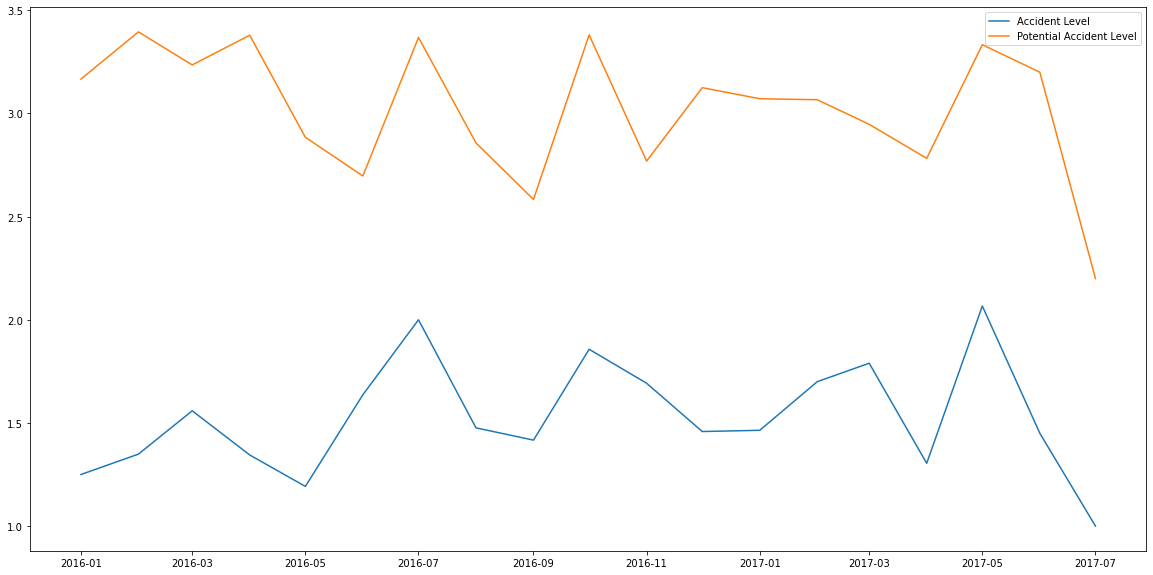

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(timeline['months'], timeline['Accident_Level'], label = 'Accident Level')
plt.plot(timeline['months'], timeline['Potential_Accident_Level'], label = 'Potential Accident Level')
plt.legend()
plt.show()

This is a timeline of accidents base on the average per month. However, we can see that there is no exact relationship between time and accidents, so we should examine the columns more closely. 

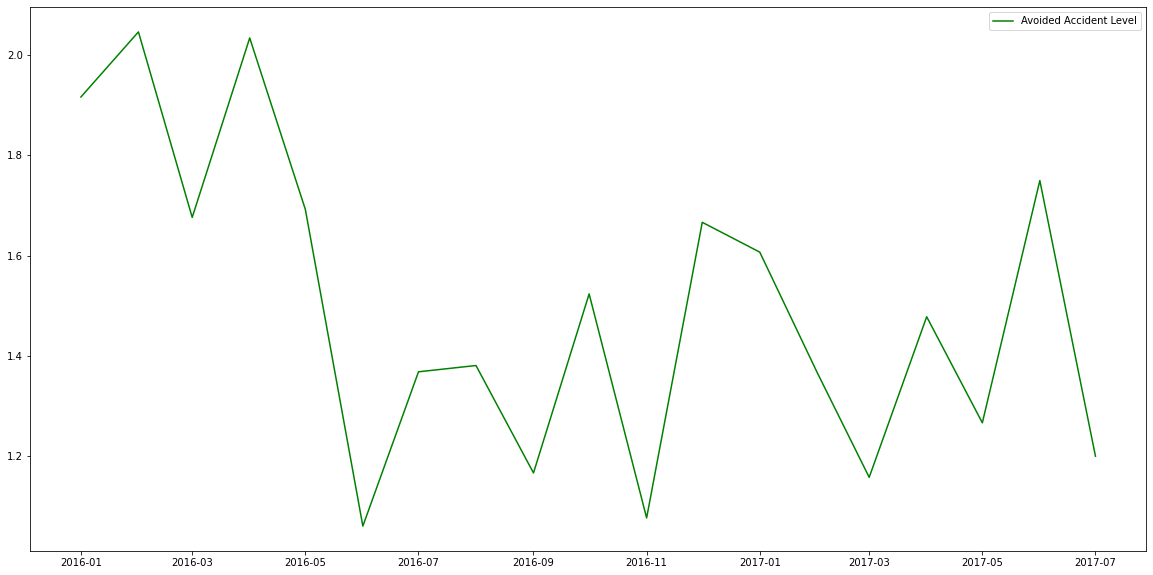

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(timeline['months'], timeline['Avoided_Accident_Level'], label = 'Avoided Accident Level', 
         color = "green")
plt.legend()

The avoided accident level, the difference between the accident and the potential accident, is plotted here against time.

# Exploring Gender

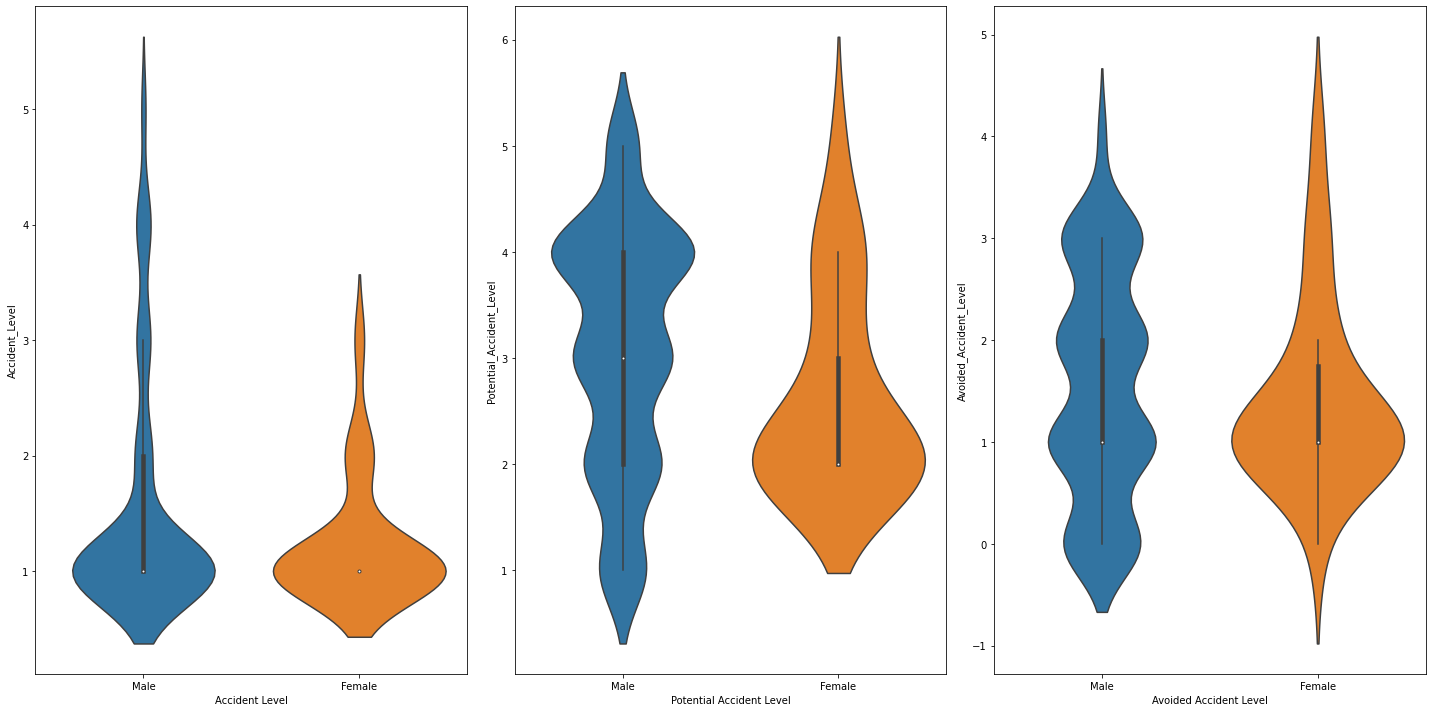

In [21]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x = "Gender", y = "Accident_Level", data = indust, split = True)
ax.set_xlabel("Accident Level")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x = "Gender", y = "Potential_Accident_Level", data = indust, split = True)
ax.set_xlabel("Potential Accident Level")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x = "Gender", y = "Avoided_Accident_Level", data = indust, split = True)
ax.set_xlabel("Avoided Accident Level")

fig.tight_layout()
plt.show()

Examining the violin plots here, we can see that the accident levels for both females and males are more clustered around level 1, but the males are more distributed and widespread than the female. However, when we examine the the potential accident levels for the males and females, the female is more clustered around a level of 2, meaning that the females were more exposed to low level potential accidents compared to the men, which had a median of 3 and a clustering around 4. But it is important to say that the male potential accident was also heavily distributed. A good idea to point out is that we only had 22 female samples, compared to 419 male samples, so perhaps looking at gender is not a good idea as we need more sample to really come to a dense conclusion if males on average are more exposed to higher level potential accidents compared to the female. Since the data is skewed, it's best to examine the median as the average. 

In [22]:
gender_acc = indust.groupby("Gender")[['Accident_Level', 'Potential_Accident_Level', 'Avoided_Accident_Level']].median().reset_index()
gender_acc

,Gender,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level
0,Female,1.0,2.0,1.0
1,Male,1.0,3.0,1.0


In [23]:
gender = indust.groupby("Gender")[['Accident_Level']].count().reset_index()

gender_perct = [round(i, 3) for i in [gender['Accident_Level'][0] / sum(gender['Accident_Level']),
                                      gender['Accident_Level'][1] / sum(gender['Accident_Level'])]]

print(gender)
pd.DataFrame({'Percentage': gender_perct}, index = ['Female', 'Male'])

   Gender  Accident_Level
0  Female              22
1    Male             417


,Percentage
Female,0.05
Male,0.95


We can see that the femal gender only occupies 5% of the dataset so it's harder to explore this part of the data as we only have 22 females in the total 429 sample. In order to see if gender plays a rolw in accidents, we would need more data.

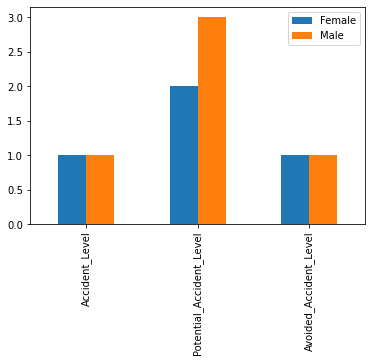

In [24]:
gen = gender_acc.T
gen.drop("Gender", axis = 0, inplace = True)
gen.rename(columns = {0 : 'Female', 1 : 'Male'}, inplace = True)
gen.plot.bar()
plt.show()

# Exploring Industry

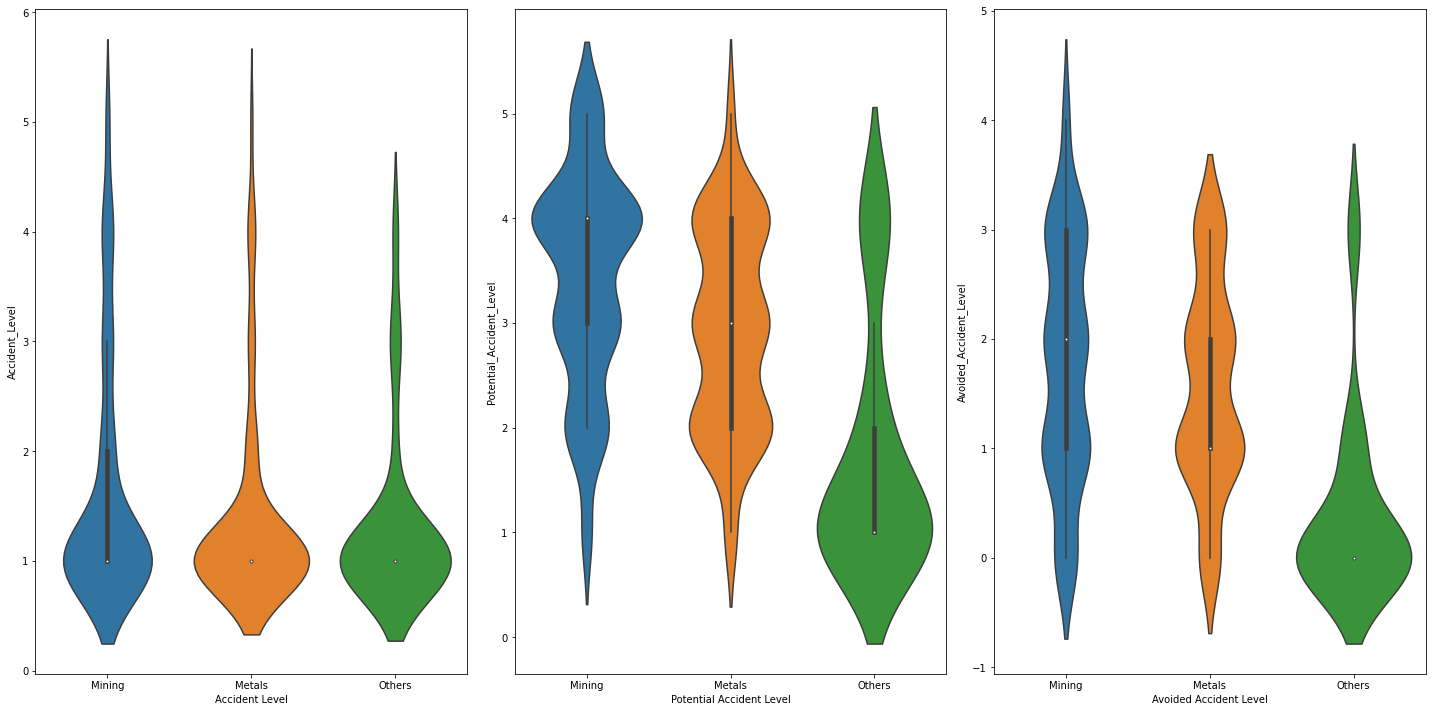

In [25]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x = "Industry", y = "Accident_Level", data = indust, split = True)
ax.set_xlabel("Accident Level")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x = "Industry", y = "Potential_Accident_Level", data = indust, split = True)
ax.set_xlabel("Potential Accident Level")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x = "Industry", y = "Avoided_Accident_Level", data = indust, split = True)
ax.set_xlabel("Avoided Accident Level")

fig.tight_layout()
plt.show()

Observing the violin plots, we can see that all the industry have a median of 1 and clusters at 1 for the accident level. We can also see that it is right-skewed, so like before, using the median as the average would be better. Examining the Potential Accident Level, we can see that Mining has a median around a level 4, Metals has a median around 3, and Others has a median around 1. It is important to point out that in the metals industry, they seem to be evenly cluster around 2, 3, and 4. We can see that the potential accident level are more well-spread but the actual accident levels for all the industrys are not as heavily spread and more tied to level 1. 

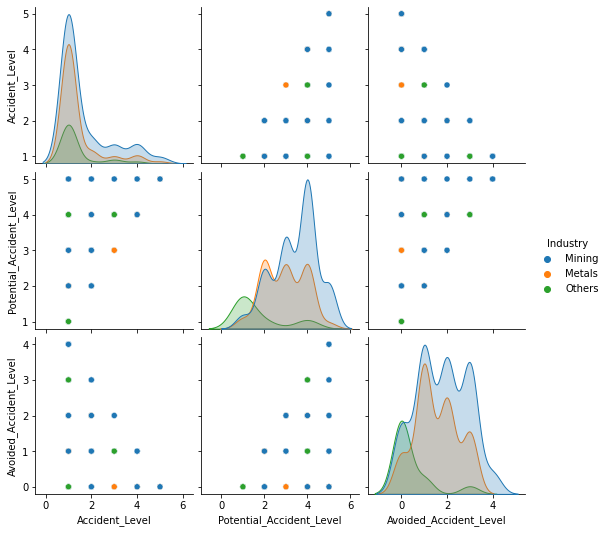

In [26]:
sns.pairplot(indust, hue = 'Industry')

Observing the kernel density plots, we can see that the Mining industry has the highest density of higher potential accident levels, but metals have the widest distribution. We can also see that the accident level is right skewed for each industry, so it's better to use the median as the count of where most of the data lies. 

In [27]:
indust.groupby("Industry")[['Accident_Level', 'Potential_Accident_Level', 'Avoided_Accident_Level']].median().reset_index()


,Industry,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level
0,Metals,1.0,3.0,1.0
1,Mining,1.0,4.0,2.0
2,Others,1.0,1.0,0.0


In [28]:
indust.groupby("Industry")[['Accident_Level']].count().reset_index()

,Industry,Accident_Level
0,Metals,148
1,Mining,241
2,Others,50


In [29]:
indust_reg = smf.ols(formula = 'Accident_Level ~ Potential_Accident_Level*Industry', data = indust)
# metal_reg = sm.OLS(metals['Accident_Level'], metals['Potential_Accident_Level']).fit()
indust_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Accident_Level   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     30.74
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           9.13e-27
Time:                        15:40:14   Log-Likelihood:                -569.09
No. Observations:                 439   AIC:                             1150.
Df Residuals:                     433   BIC:                             1175.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.0020      0.236      0.008      0.993      -0.461       0.465
Industry[T.Mining]                             -0.1375      0.309     -0.445      0.657      -0.746       0.471
Industry[T.Others]                              0.5247      0.327      1.604      0.109      -0.118       1.167
Potential_Accident_Level                        0.4729      0.076      6.202      0.000       0.323       0.623
Potential_Accident_Level:Industry[T.Mining]     0.0485      0.095      0.513      0.608      -0.137       0.234
Potential_Accident_Level:Industry[T.Others]    -0.0116      0.133     -0.087      0.931      -0.274       0.251
==============================================================================
Omnibus:                       57.194   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.224
Skew:                           0.964   Prob(JB):                     2.81e-17
Kurtosis:                       3.673   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examining the metal industry, the equation of the linear equation is:

$Accident Level = 0.0020 + -0.1375\times Mining + 0.5247 \times Others + (0.4729 + 0.0485 \times Mining + -0.0116 \times Others) \times Potential Accident Level$

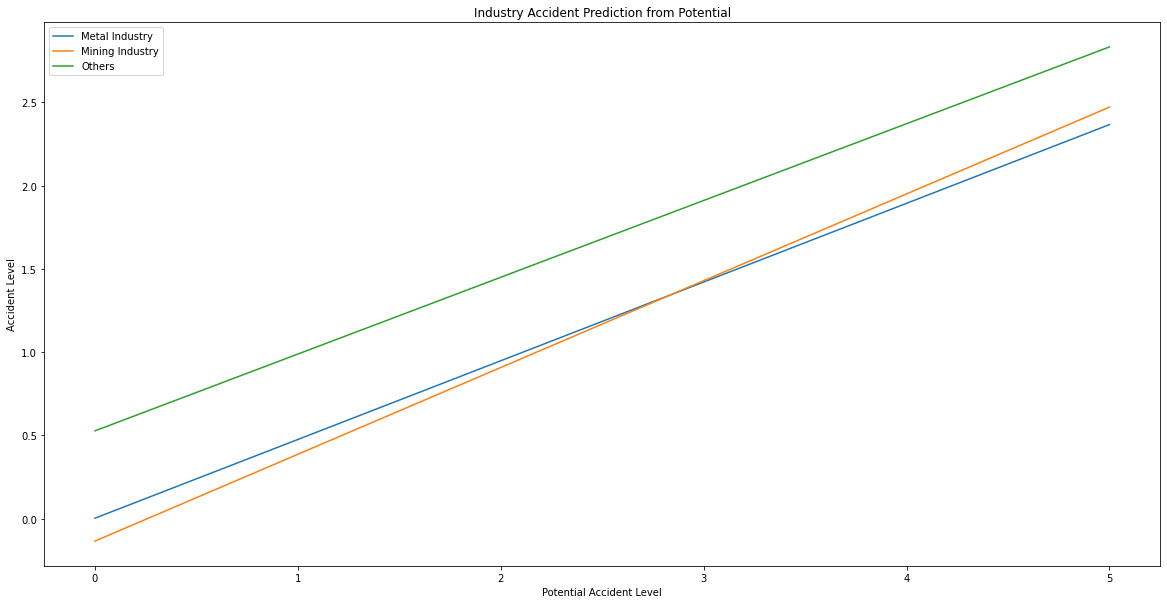

In [30]:
plt.figure(figsize = (20, 10))
x = np.array(range(6))
y_metals = 0.0020 + 0.4729 * x
y_mining = -0.1355 + 0.5214 * x
y_others = 0.5267 + 0.4613 * x

plt.plot(x, y_metals, label = "Metal Industry")
plt.plot(x, y_mining, label = "Mining Industry")
plt.plot(x, y_others, label = "Others")

plt.title("Industry Accident Prediction from Potential")
plt.xlabel("Potential Accident Level")
plt.ylabel("Accident Level")

plt.legend()
plt.show()

Observing the linear regression, we can see that others occur higher accident levels given a potential accident level and mining is the least. However, mining has the steepest slope, indicating that they will gain higher accident levels as the potential accident level increases. From this graph, we can conclude that although others may incur higher accidents, mining has a trade off between safety and damages. 

# Exploring Employee or Third Party

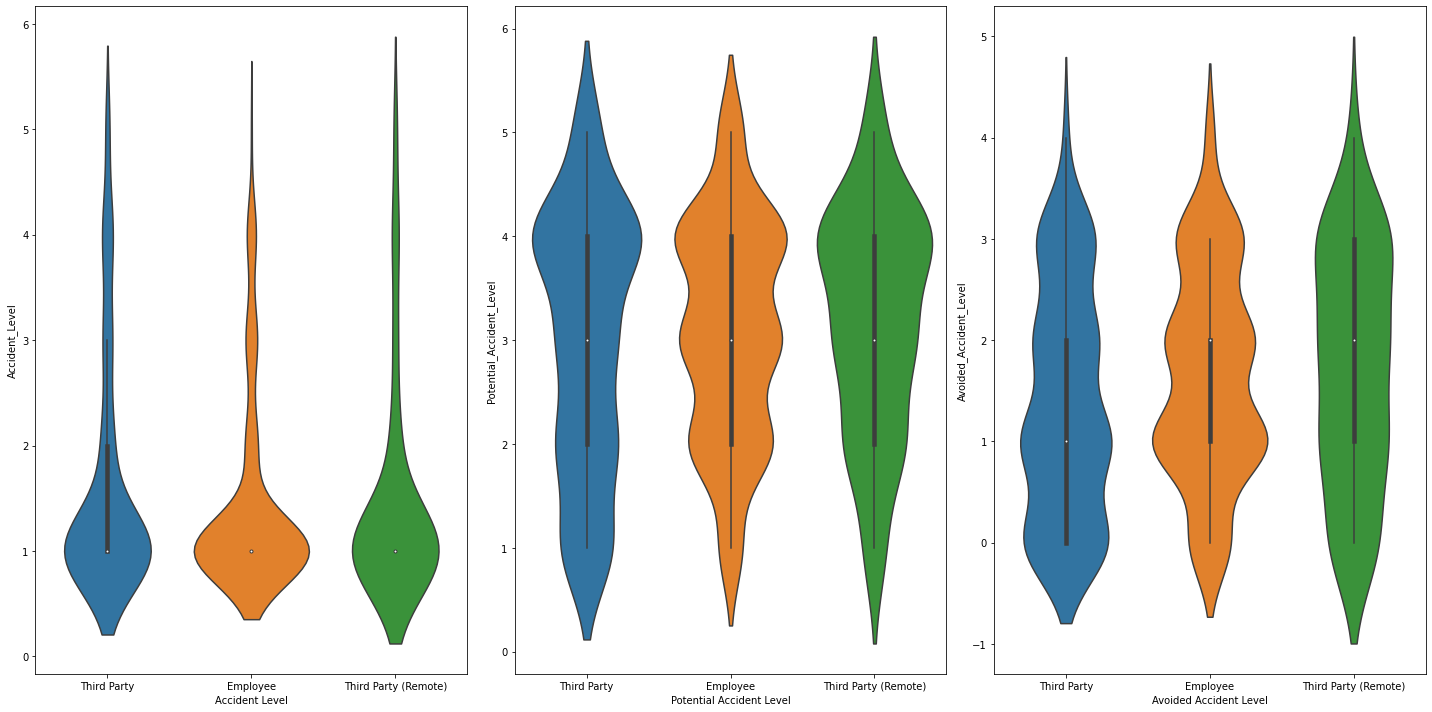

In [31]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x = "Employee_or_Third_Party", y = "Accident_Level", data = indust, split = True)
ax.set_xlabel("Accident Level")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x = "Employee_or_Third_Party", y = "Potential_Accident_Level", data = indust, split = True)
ax.set_xlabel("Potential Accident Level")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x = "Employee_or_Third_Party", y = "Avoided_Accident_Level", data = indust, split = True)
ax.set_xlabel("Avoided Accident Level")

fig.tight_layout()
plt.show()

Observing the violin plots for the different types of employees, we can see that it is still right skewed for the accident level at level 1. The potnetial accident level are more widespread however but seems to be a bit more clustered around 4 but with a median of 3. The avoided accident level is interesting for Third Party as all three employee status had relatvely the same median, but for the third party, it has a median of 1 compared to 2 for the others. 

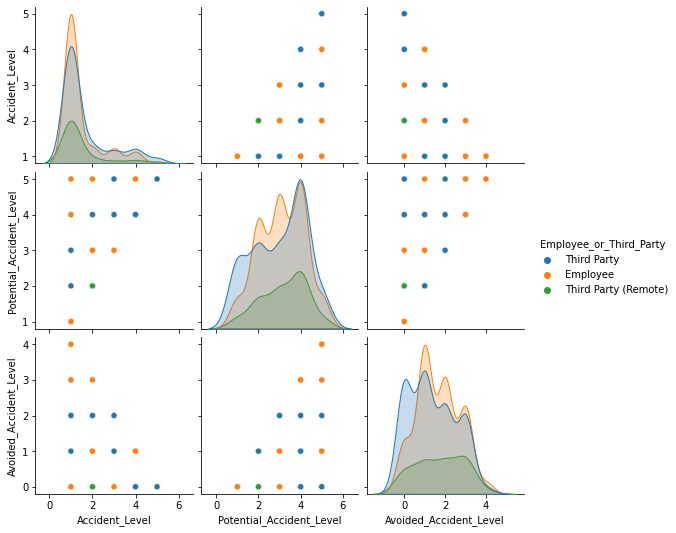

In [32]:
sns.pairplot(indust, hue = 'Employee_or_Third_Party')

Observing the kernel density graph of the employee status, we can see that the third party had a wide spread and distribution of potential accident levels, which explains the peciular different median the third party had compared to the different employee statuses. 

In [33]:
indust.groupby("Employee_or_Third_Party")[['Accident_Level', 'Potential_Accident_Level', 'Avoided_Accident_Level']].median().reset_index()


,Employee_or_Third_Party,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level
0,Employee,1.0,3.0,2.0
1,Third Party,1.0,3.0,1.0
2,Third Party (Remote),1.0,3.0,2.0


In [34]:
indust.groupby("Employee_or_Third_Party")[['Accident_Level']].count().reset_index()

,Employee_or_Third_Party,Accident_Level
0,Employee,181
1,Third Party,189
2,Third Party (Remote),69


In [35]:
employee_reg = smf.ols(formula = 'Accident_Level ~ Potential_Accident_Level*Employee_or_Third_Party', data = indust)
# metal_reg = sm.OLS(metals['Accident_Level'], metals['Potential_Accident_Level']).fit()
employee_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Accident_Level   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     29.79
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           5.08e-26
Time:                        15:40:18   Log-Likelihood:                -570.86
No. Observations:                 439   AIC:                             1154.
Df Residuals:                     433   BIC:                             1178.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    0.2209      0.206      1.073      0.284      -0.184       0.626
Employee_or_Third_Party[T.Third Party]                                      -0.0812      0.266     -0.305      0.760      -0.604       0.442
Employee_or_Third_Party[T.Third Party (Remote)]                              0.0669      0.397      0.169      0.866      -0.713       0.847
Potential_Accident_Level                                                     0.3947      0.063      6.263      0.000       0.271       0.519
Potential_Accident_Level:Employee_or_Third_Party[T.Third Party]              0.1020      0.082      1.250      0.212      -0.058       0.262
Potential_Accident_Level:Employee_or_Third_Party[T.Third Party (Remote)]    -0.0258      0.119     -0.217      0.828      -0.260       0.208
==============================================================================
Omnibus:                       62.326   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.428
Skew:                           1.019   Prob(JB):                     2.81e-19
Kurtosis:                       3.719   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examining the employee industry, the equation of the linear equation is:

$Accident Level = 0.2209 + -0.0812\times Third Party + 0.0669 \times Remote Third Party + (0.3947 + 0.1020 \times Third Party + -0.0258 \times Remote Third Party) \times Potential Accident Level$

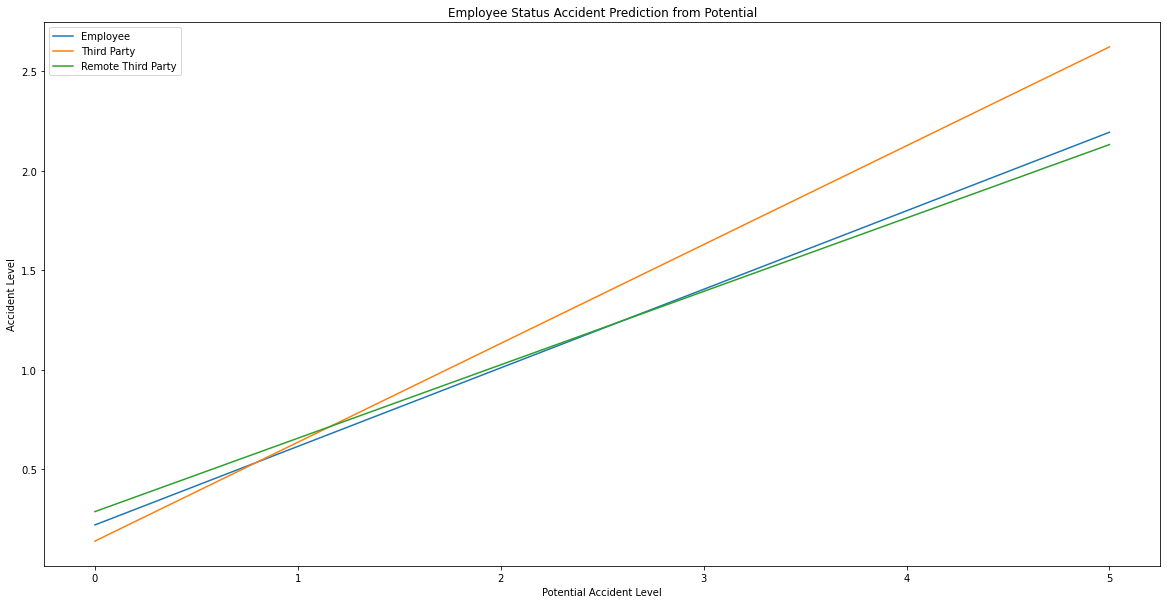

In [36]:
plt.figure(figsize = (20, 10))
x = np.array(range(6))
y_employee = 0.2209 + 0.3947 * x
y_thirdparty = 0.1397 + 0.4967 * x
y_remotethirdparty = 0.2878 + 0.3689 * x

plt.plot(x, y_employee, label = "Employee")
plt.plot(x, y_thirdparty, label = "Third Party")
plt.plot(x, y_remotethirdparty, label = "Remote Third Party")

plt.title("Employee Status Accident Prediction from Potential")
plt.xlabel("Potential Accident Level")
plt.ylabel("Accident Level")

plt.legend()
plt.show()

## Exploring Countries

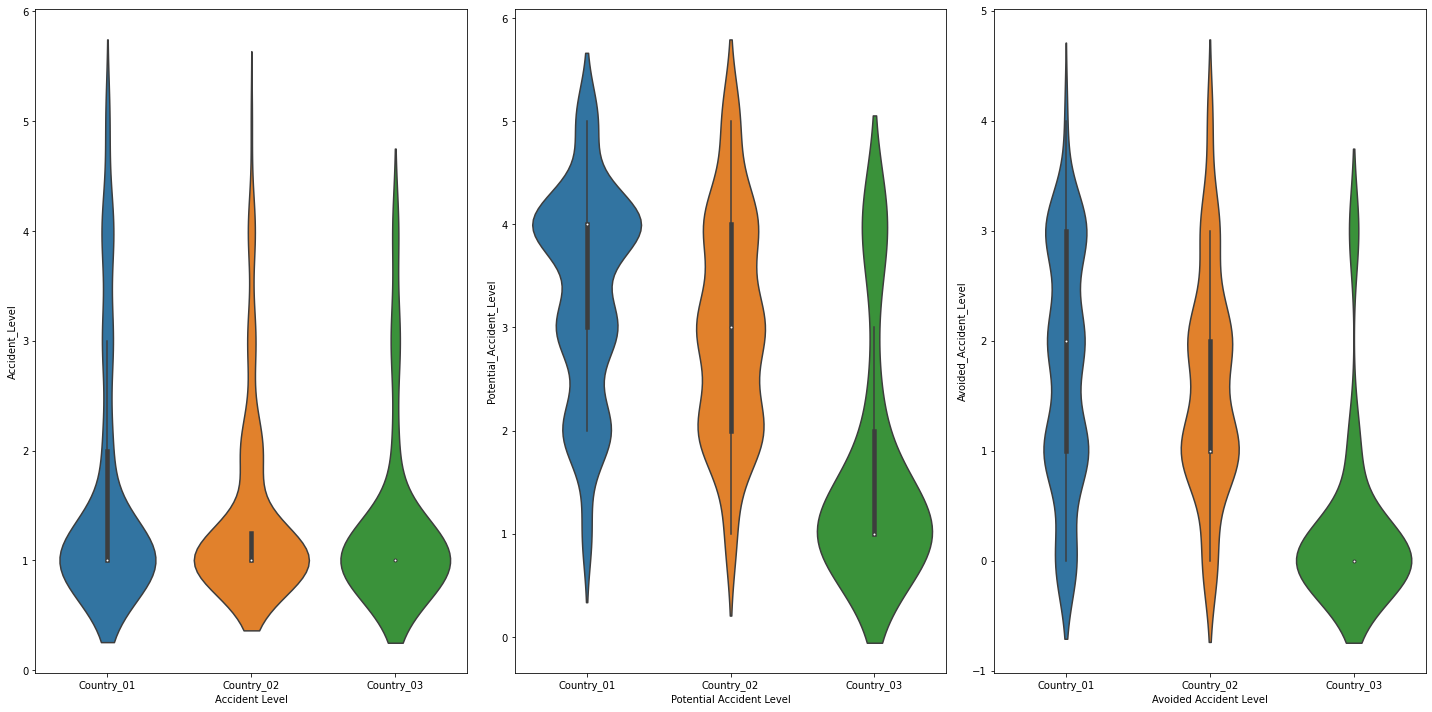

In [37]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(x = "Countries", y = "Accident_Level", data = indust, split = True)
ax.set_xlabel("Accident Level")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(x = "Countries", y = "Potential_Accident_Level", data = indust, split = True)
ax.set_xlabel("Potential Accident Level")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(x = "Countries", y = "Avoided_Accident_Level", data = indust, split = True)
ax.set_xlabel("Avoided Accident Level")

fig.tight_layout()
plt.show()

Observing the violin plots, we can see that all three countries cluster around an accident level of 1, but the potential accident level tells a different story. We see that Country 1 has a median potential accident level of 4, Country 2 has it at 3, and Country 3 has it at 1. We also see that Country 1 and Country 2 are exposed to a wider distribution of potential accidents. 

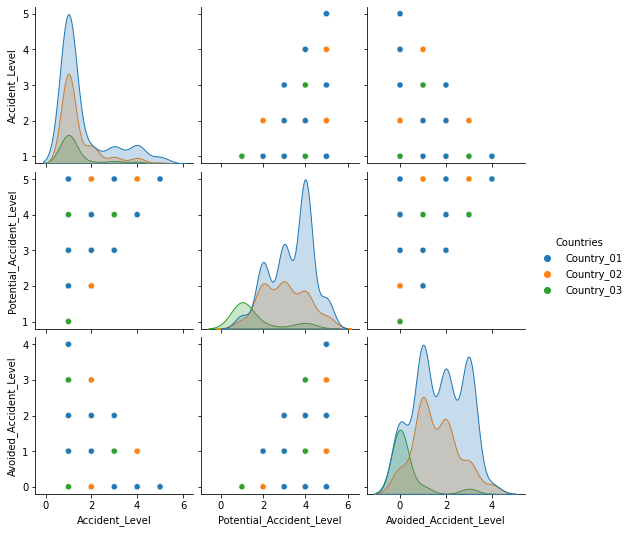

In [38]:
sns.pairplot(indust, hue = 'Countries')

Examining the kernel density of the three countries, we can see that country 1 are more exposed to higher potential accident levels but country 2 has a wider distribution. We can also wee that the accident level for each country is indeed right-skewed, so it's best to use the median as an average.

In [39]:
indust.groupby("Countries")[['Accident_Level', 'Potential_Accident_Level', 'Avoided_Accident_Level']].median().reset_index()


,Countries,Accident_Level,Potential_Accident_Level,Avoided_Accident_Level
0,Country_01,1.0,4.0,2.0
1,Country_02,1.0,3.0,1.0
2,Country_03,1.0,1.0,0.0


In [40]:
indust.groupby("Countries")[['Accident_Level']].count().reset_index()


,Countries,Accident_Level
0,Country_01,263
1,Country_02,132
2,Country_03,44


In [41]:
country_reg = smf.ols(formula = 'Accident_Level ~ Potential_Accident_Level*Countries', data = indust)
# metal_reg = sm.OLS(metals['Accident_Level'], metals['Potential_Accident_Level']).fit()
country_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Accident_Level   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     31.87
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.19e-27
Time:                        15:40:21   Log-Likelihood:                -566.98
No. Observations:                 439   AIC:                             1146.
Df Residuals:                     433   BIC:                             1170.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -0.2548      0.189     -1.346      0.179      -0.627       0.117
Countries[T.Country_02]                              0.4977      0.301      1.652      0.099      -0.095       1.090
Countries[T.Country_03]                              0.7604      0.302      2.517      0.012       0.167       1.354
Potential_Accident_Level                             0.5597      0.054     10.322      0.000       0.453       0.666
Potential_Accident_Level:Countries[T.Country_02]    -0.1695      0.091     -1.854      0.064      -0.349       0.010
Potential_Accident_Level:Countries[T.Country_03]    -0.0562      0.132     -0.426      0.670      -0.315       0.203
==============================================================================
Omnibus:                       53.442   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.664
Skew:                           0.930   Prob(JB):                     7.46e-16
Kurtosis:                       3.592   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examining the countries, the equation of the linear equation is:

$Accident Level = -0.2548 + 0.4977\times Country 2 + 0.7604 \times Country 3 + (0.5597 + -0.1695 \times Country 2 + -0.0562 \times Country 3) \times Potential Accident Level$

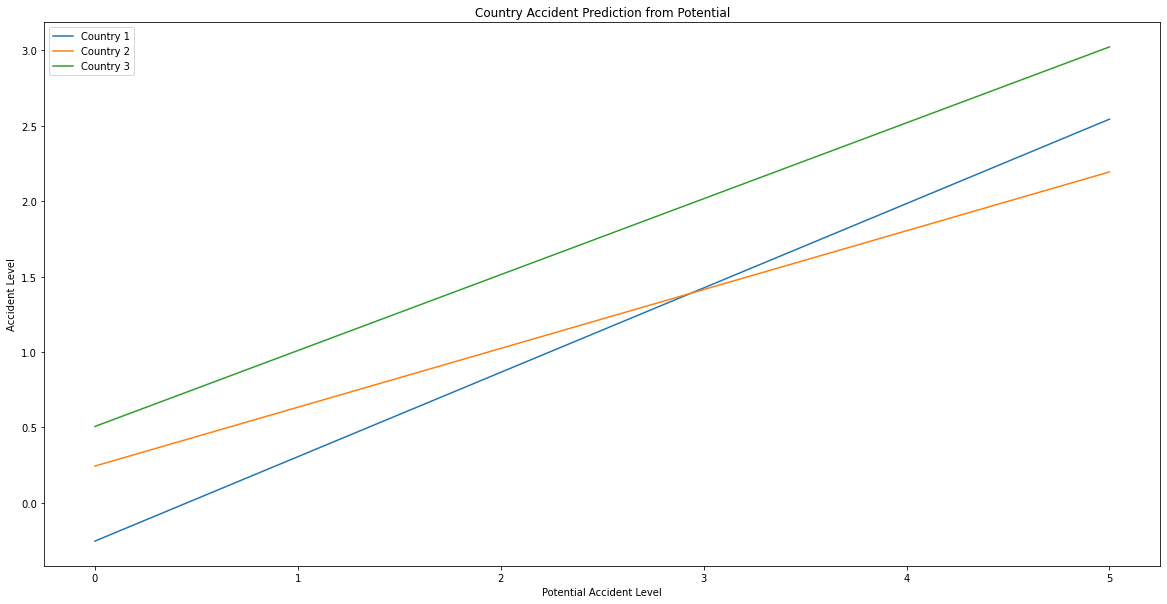

In [42]:
plt.figure(figsize = (20, 10))
x = np.array(range(6))
y_country1 = -0.2548 + 0.5597 * x
y_country2 = 0.2429 + 0.3902 * x
y_country3 = 0.5056 + 0.5035 * x

plt.plot(x, y_country1, label = "Country 1")
plt.plot(x, y_country2, label = "Country 2")
plt.plot(x, y_country3, label = "Country 3")

plt.title("Country Accident Prediction from Potential")
plt.xlabel("Potential Accident Level")
plt.ylabel("Accident Level")

plt.legend()
plt.show()

Exploring countries, we can see that Country 3 have a higher accident level given a potential accident level and country 1 have the steepest slope. Meaning that although Country 1 may have a smaller accident level given a potential level, there is a higher rate of actual accident level as the potential accident level increases.

## Conclusion

After examiing all the linear regression, we can conclude that the best relationship to predict accidents from potential accidents is the countries one. Out of all the linear regression we have performed, it has the highest R-squared value out of all of it at 0.296. We can also examine the t values from the linear regression summary that at the 10% level, most of the coefficients are significant enough to not be 0. The most accurate equation would be:

$Accident Level = -0.2548 + 0.4977\times Country 2 + 0.7604 \times Country 3 + (0.5597 + -0.1695 \times Country 2 + -0.0562 \times Country 3) \times Potential Accident Level$

I would reccomend that we need more columns in order to create a better linear regression model to predict accidents from potential accidents and other categorical variables that may help. I can only hypothesize that the different Countries linear regression fits the best because different countries have different policies on safety, and some may be more lenient than others. In general, I feel this dataset is a bit incomplete and more research and data gathering would need to be down. Data such as helmet wear, fatigue level, age, medical issues, or hours worked would all work and may also shed more light on what is causing these accidents. 